In [1]:
#!pip install pyarrow
#!pip install --upgrade pandas scikit-learn


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
pd.__version__

'1.4.2'

In [4]:
url='https://d37ci6vzurychx.cloudfront.net/trip-data/'

# 
df1 = pd.read_parquet(url+'yellow_tripdata_2024-01.parquet')
df1['filename'] = '2024-01'
#df2 = pd.read_parquet(url+'yellow_tripdata_2024-02.parquet')
#df2['filename'] =  '2024-02'

# 
df=df1
#df = pd.concat([df1, df2])


In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,filename
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,2024-01
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,2024-01
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,2024-01
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,2024-01
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,2024-01


In [6]:
#Q1: Read the data for January. How many columns are there?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [8]:
#Q2: What's the standard deviation of the trips duration in January?

In [9]:
df_january = df[df['filename'] == '2024-01'].copy()
df_january['duration'] = df_january['tpep_dropoff_datetime'] - df_january['tpep_pickup_datetime']
df_january.duration = df_january.duration.apply(lambda td: td.total_seconds() / 60)

std_value = df_january['duration'].std()

print(f"the standard deviation of the trips duration in January: {std_value}")

the standard deviation of the trips duration in January: 34.851053592192876


In [10]:
# Q3: Dropping outliers, What fraction of the records left after you dropped the outliers?

In [11]:
df_filter = df_january[(df_january['duration'] >= 1) & (df_january['duration'] <= 60)].copy()

fraction_dropped = len(df_filter) / len(df_january)

print(f"The fraction of the records left after I dropped the outliers is: {fraction_dropped:.2%}")

The fraction of the records left after I dropped the outliers is: 97.78%


In [12]:
#Q4 What's the dimensionality of this matrix (number of columns)?

In [13]:
# Re-cast the pickup and dropoff location IDs to strings
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_filter[categorical] = df_filter[categorical].astype(str)
#df_filter.loc[:, categorical] = df_filter[categorical].astype(str)

# Convert the DataFrame to a list of dictionaries
train_dicts = df_filter[categorical].to_dict(orient='records')

In [14]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898906 entries, 0 to 2964623
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           object        
 8   DOLocationID           object        
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [15]:
# Fit a DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [16]:
# Get the dimensionality of the matrix
num_columns = X_train.shape[1]

print(f"The fraction of the records left after I dropped the outliers is: {num_columns}")

The fraction of the records left after I dropped the outliers is: 518


In [17]:
#Q5: What's the RMSE on train?

In [18]:
import numpy as np

In [19]:
# The target variable
y_train = df_filter['duration']

# Train a plain linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the training data
y_pred = model.predict(X_train)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print(f"The RMSE on the training data is: {rmse:.2f}")


The RMSE on the training data is: 7.95


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


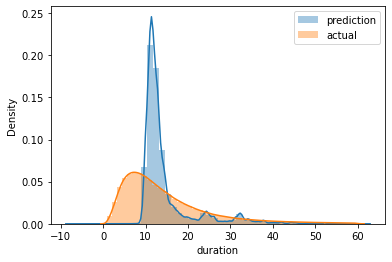

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [21]:
#Q6: Evaluating the model

In [22]:
#with open('lin_reg.bin', 'wb') as f_out:
#    pickle.dump((dv, model), f_out)

In [23]:
df_val = pd.read_parquet(url+'yellow_tripdata_2023-02.parquet')
df_val['filename'] = '2023-02'
df_val['duration'] = df_val['tpep_dropoff_datetime'] - df_val['tpep_pickup_datetime']
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

In [24]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913955 entries, 0 to 2913954
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [29]:
#dv = DictVectorizer()
val_dicts = df_val[categorical].to_dict(orient='records')
X_train1 = dv.transform(val_dicts)


# Predice en los datos de validación
y_val_pred = model.predict(X_train1)

# Calcula el RMSE en los datos de validación
rmse_val = np.sqrt(mean_squared_error(df_val['duration'], y_val_pred))



In [30]:
#mean_squared_error(y_train, y_pred, squared=False)

In [32]:
rmse202302 = np.sqrt(mean_squared_error(df_val['duration'], y_val_pred))
print(f"Calculate the RMSE: {rmse202302:.2f}")

Calculate the RMSE: 43.56
